# Debt

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Read Central Goverment Debt


In [62]:
central_gov_debt = pd.read_excel("data/central-gov-debt.xls", index_col=0, na_values=["no data"]).dropna(how="all")
central_gov_debt.index.set_names(["country_name"], inplace=True)
central_gov_debt.columns.set_names(["year"], inplace=True)
central_gov_debt = central_gov_debt.unstack().to_frame("debt_to_gdp").reorder_levels([1, 0]).sort_index()
central_gov_debt

debt_to_gdp
country_name year             
Afghanistan  1950          NaN
             1951          NaN
             1952          NaN
             1953          NaN
             1954          NaN
...                        ...
Zimbabwe     2016    49.095958
             2017    54.432665
             2018    61.486042
             2019   113.922830
             2020    86.146514

[12354 rows x 1 columns]

## Read General Goverment Debt
In some countries (e.g. The Netherlands) the goverment is fully in charge of all debt of the country. This means that for these countries no Central Goverment Debt to GDP ratio exists. Thus for these countries we import the General Government Debt. 

In [63]:
general_gov_debt = pd.read_excel("data/general-gov-debt.xls", index_col=0, na_values=["no data"]).dropna(how="all")
general_gov_debt.index.set_names(["country_name"], inplace=True)
general_gov_debt.columns.set_names(["year"], inplace=True)
general_gov_debt = general_gov_debt.unstack().to_frame("debt_to_gdp").reorder_levels([1, 0]).sort_index()
general_gov_debt

debt_to_gdp
country_name year             
Albania      1950          NaN
             1951          NaN
             1952          NaN
             1953          NaN
             1954          NaN
...                        ...
Yemen        2016    72.255354
             2017    77.426337
             2018    74.543975
             2019    76.527015
             2020    84.165724

[6248 rows x 1 columns]

## Combine Central Gov. and General Gov debts

If there is no Central Government data for that country or year, then use the General Government debt data.

In [64]:
general_gov_countries = general_gov_debt.index
central_gov_countries = central_gov_debt.index
append_years = ~general_gov_countries.isin(central_gov_countries)
append_values = general_gov_debt[append_years]
debt_gdp = pd.concat([central_gov_debt, append_values])

<AxesSubplot:xlabel='year'>

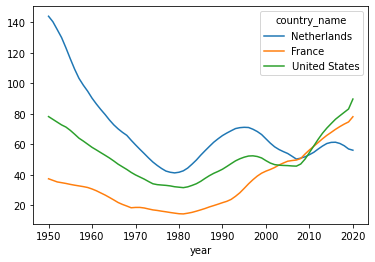

In [65]:
debt_gdp.loc[["Netherlands", "France", "United States"], "debt_to_gdp"].unstack(level=0).ewm(span=10,adjust=False).mean().plot()

## Get 5 year mean

In [66]:
debt_to_gdp_25_year = debt_gdp.loc[(debt_gdp.index.get_level_values(1) >= 2015) & (debt_gdp.index.get_level_values(1) <= 2020)]
debt_gdb_25 = debt_to_gdp_25_year.groupby(debt_to_gdp_25_year.index.get_level_values(0)).mean()
debt_gdb_25

,debt_to_gdp
country_name,
Afghanistan,7.750221
Albania,70.860451
Algeria,32.528441
Angola,90.861074
Antigua and Barbuda,91.290081
...,...
Vietnam,47.093550
West Bank and Gaza,35.781772
Yemen,73.658282


## Read Democracy Data

In [67]:
dem: pd.DataFrame = pd.read_hdf("data/democracy.h5", "democracy")
dem_average = dem.groupby(dem.index.get_level_values(0)).mean()
dem_average

,econ-score,free-score,v-dem-score,score
country_name,,,,
Afghanistan,0.270500,0.208333,0.253783,0.244206
Albania,0.584750,0.666667,0.400400,0.550606
Algeria,0.362000,0.250000,0.216650,0.276217
Angola,0.334667,0.229167,0.158883,0.240906
Argentina,0.687000,0.833333,0.620133,0.713489
...,...,...,...,...
Venezuela,0.465833,0.305556,0.213650,0.328346
Vietnam,0.307667,0.166667,0.187100,0.220478
Yemen,0.251000,0.166667,0.135683,0.184450


## Create Plot

In [68]:
debt_dem = debt_gdb_25.join(dem_average["score"], how="inner").dropna()
debt_dem

,debt_to_gdp,score
country_name,,
Afghanistan,7.750221,0.244206
Albania,70.860451,0.550606
Algeria,32.528441,0.276217
Angola,90.861074,0.240906
Argentina,73.235302,0.713489
...,...,...
Venezuela,50.875228,0.328346
Vietnam,47.093550,0.220478
Yemen,73.658282,0.184450


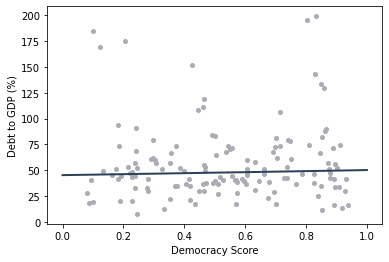

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            debt_to_gdp   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2671
Date:                Mon, 31 Jan 2022   Prob (F-statistic):              0.606
Time:                        13:09:25   Log-Likelihood:                -122.75
No. Observations:                 141   AIC:                             249.5
Df Residuals:                     139   BIC:                             255.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8132      0.117     32.498      0.000       3.581       4.045
score          0.1026      0.199      0.517      0.606      -0.290       0.495
==============================================================================
Omnibus:                        2.844   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.797
Skew:                          -0.095   Prob(JB):                        0.247
Kurtosis:                       3.663   Cond. No.                         5.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
model = sm.OLS(np.log(debt_dem["debt_to_gdp"]), sm.add_constant(debt_dem["score"]))
res = model.fit()
plt.scatter(debt_dem["score"], debt_dem["debt_to_gdp"], 16, marker="o", color="#ADACB5")
x = np.linspace(0, 1)
plt.plot(x, np.exp(res.params[0] + res.params[1]*x), linewidth=2, color="#2E4057")
plt.xlabel("Democracy Score")
plt.ylabel("Debt to GDP (%)")
plt.show()
res.summary()

## Plot median debt ratio over time

In [70]:
dem_raw = pd.read_hdf("data/democracy.h5", "democracy_raw")["v-dem-score"].to_frame()
debt_dem_time = debt_gdp.join(dem_raw)
debt_dem_time

debt_to_gdp  v-dem-score
country_name year                          
Afghanistan  1950          NaN       0.0658
             1951          NaN       0.0658
             1952          NaN       0.0622
             1953          NaN       0.0624
             1954          NaN       0.0604
...                        ...          ...
Uzbekistan   2016     8.191619       0.0952
             2017    19.274350       0.1236
             2018    19.468789       0.1334
             2019    28.268768       0.1472
             2020    36.436503       0.1542

[13490 rows x 2 columns]

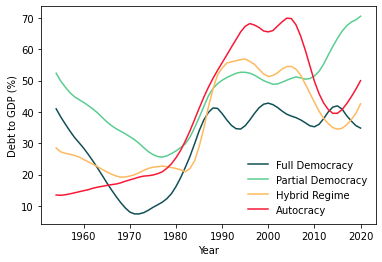

In [86]:
bins = pd.cut(debt_dem_time["v-dem-score"], bins=[0, 0.4, 0.6, 0.8, 1])
debt_dem_time_mean = debt_dem_time.groupby([bins, "year"]).mean()["debt_to_gdp"].reorder_levels([1, 0]).sort_index().unstack()

debt_dem_time_mean = debt_dem_time_mean.ewm(span=5).mean().rolling(5).mean()
debt_dem_time_mean = debt_dem_time_mean.reindex(sorted(debt_dem_time_mean.columns, reverse=True), axis=1)
colors = ["#104F55", "#59CD90", "#FEB95F", "#F71735"]
plt.gca().set_prop_cycle(color=colors)
plt.plot(debt_dem_time_mean)
plt.legend(debt_dem_time_mean.columns)
plt.xlabel("Year")
plt.ylabel("Debt to GDP (%)")
plt.legend(["Full Democracy", "Partial Democracy", "Hybrid Regime", "Autocracy"], frameon=False)
plt.show()